#**Sentiment Analysis**

##**Dataset**




In [ ]:
import pandas as pd

df = pd.read_csv("tweet_emotions_processed.csv")
df.head()

,tweet_id,sentiment,content,label,data_type
0,1956967666,sadness,layin n bed with a headache ughh...waitin <-em...,0,train
1,1956967696,sadness,funeral ceremony...gloomy friday...,0,train
2,1956968416,neutral,@men we want to trade with someone who has hou...,1,train
3,1956968477,worry,re-pinging @men: why did not you go to prom? b...,2,val
4,1956968487,sadness,"i should be sleep, but i am not! thinking abou...",0,train


This is an already processed dataset from https://www.kaggle.com/code/hadimotamedi/preprocessing/notebook

The goal is to classify a tweet to one of the following emotions:

*   sadness
*   neutral
*   worry
*   surprise
*   love
*   fun
*   hate
*   happiness
*   relief



##**Preprocessing**

In [ ]:
import re

import gensim.downloader
import numpy as np
import pandas as pd
import torch
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk
nltk.download('punkt')

def remove_tags(text):
    cleaned_text = re.sub(re.compile('<.*?>@'), '', text)
    return cleaned_text

def remove_account_tag(text):
    return re.sub(r'@[\w]+', '', text)


def remove_less_2_characters(text):
    return re.sub(r"\W*\b\w{1,2}\b", '', text)

def clean(text):
    text = remove_tags(text)
    text = remove_account_tag(text)
    text = remove_less_2_characters(text)

    return text

def preprocess(df):
    df.drop(labels=["tweet_id", "label", "data_type"], axis=1, inplace=True)

    df.dropna(inplace=True)

    df.content = df.content.apply(lambda x: x.lower())

    df.content = df.content.apply(lambda x: clean(x))

    text_labels = df.sentiment.unique()

    return df, text_labels

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


The new dataset:

In [ ]:
df = pd.read_csv("tweet_emotions_processed.csv")
df, lbl = preprocess(df)
df.head()

,sentiment,content
0,0,layin bed with headache ughh...waitin <-empw y...
1,0,funeral ceremony...gloomy friday...
2,1,want trade with someone who has houston ticke...
3,2,-pinging : why did not you prom did not like f...
4,0,"should sleep, but not! thinking about old fri..."


##**Dataset analysis**

In [ ]:
from matplotlib import pyplot as plt

def bar_plot(x_labels: list, y_values: list, x_label: str, y_label: str):
    fig, ax = plt.subplots()

    ax.bar(x_labels, y_values)

    ax.set(xlabel=x_label, ylabel=y_label)

    plt.show()
    plt.close()

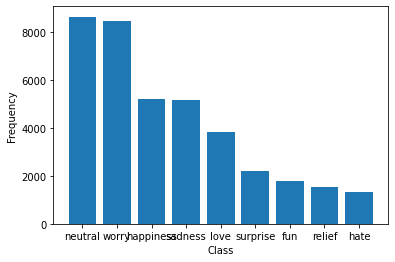

In [ ]:
df = pd.read_csv("tweet_emotions_processed.csv")
frequency = df.sentiment.value_counts().to_dict()
bar_plot(frequency.keys(), frequency.values(), "Class", "Frequency")

We notice a high class imbalance

##**Text vectorization**

For the vectorization the pretrained GloVe embedding was used

In [ ]:
def vectorize(text, vectorizer):
    vectorized_text = []
    tokenized_text = word_tokenize(text)
    for w in tokenized_text:
        try:
            vectorized_w = vectorizer[w]
            vectorized_text.append(vectorized_w)
        except:
            pass
    if vectorized_text:   
        return vectorized_text
    else:
        return False
            
def vectorize_data(df):
    #vectorize text
    model = gensim.downloader.load('glove-twitter-25')
    df.content = df.content.apply(lambda x: vectorize(x, model))

    df = df[df.content != False]

    #pad vectorized elements so they all have the same length
    content_lengths = df.content.copy(deep=True)
    content_lengths = content_lengths.apply(lambda x: len(x))
    max_length = max(content_lengths)

    df.content = df.content.apply(lambda x: np.pad(x, ((0, max_length - len(x)), (0, 0)), mode='constant'))
    
    return df

##**Split train test**

Due to class imbalance observed in the dataset the stratified version of the train_test_split() function was used to ensure a similar distribution of each class in the train and test set.

80% of the dataset was used for training and 20% for test

In [ ]:
def get_train_test(csv="tweet_emotions_processed.csv"):
    #clean text
    df = pd.read_csv(csv)
    df, text_labels = preprocess(df)
    df.sentiment = df.sentiment.replace(dict(zip(df.sentiment.unique(), range(len(df.sentiment.unique())))))

    #vectorize text
    df = vectorize_data(df)

    x = df.content.values
    x = [x[i] for i in range(len(x))]
    x = np.reshape(x, (len(x), len(x[0]) * len(x[0][0])))
    x = [x[i].astype(np.float32) for i in range(len(x))]
    x = np.array(x)
    x = torch.tensor(x)

    y = df.sentiment.values
    y = y.astype(np.float32)
    y = [[value] for value in y]
    y = torch.tensor(y)

    x_train, x_test, y_train, y_test =  train_test_split(x, y, test_size=0.2, stratify=y)

    return ([x_train, y_train], [x_test, y_test])

##**Time wrapper**

In [ ]:
from functools import wraps
import time

def measure_time(func):
    @wraps(func)
    def measure_time_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'Function {func.__name__} took {total_time:.4f} seconds')
        return result
    return measure_time_wrapper

##**Classifier class**


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             confusion_matrix, precision_recall_fscore_support)

def get_labels_text(csv="tweet_emotions_processed.csv"):
    df = pd.read_csv(csv)
    df, text_labels = preprocess(df)

    return text_labels

class Classifier:
    def __init__(self, classifier):
        self.classifier = classifier

    @measure_time
    def train(self, x, y):
        self.classifier.fit(x, y)

    @measure_time
    def pred(self, x):
        predicted = self.classifier.predict(x)
        return predicted

    def display_metrics(self, y_true, y_pred):
        #accuracy
        print(f"set accuracy: {accuracy_score(y_true, y_pred)}")

        #confusion matrix
        print("confusion_matrix:")
        ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot()

        #metrics table 
        fig, ax  = plt.subplots() 
        ax.axis('tight')
        ax.axis('off')

        prfs = precision_recall_fscore_support(y_true, y_pred)
        prfs = np.array(prfs, dtype=np.float32)

        columns = get_labels_text()
        rows = ["precision", "recall", "f-score", "support"]

        table = ax.table(cellText=prfs, rowLabels=rows, colLabels=columns, loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(14)
        table.scale(3.5, 3.5)
    
        plt.show()
        plt.close()

##**knn and nearest centroid classifiers**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid

#load data
train_data, test_data = get_train_test()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


<class 'torch.Tensor'>


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Function train took 0.0499 seconds
Function pred took 26.2327 seconds
set accuracy: 0.19868507560815254
confusion_matrix:


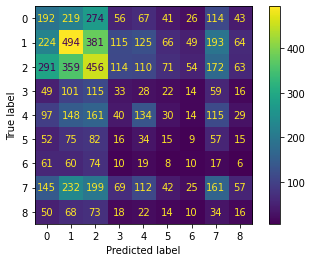

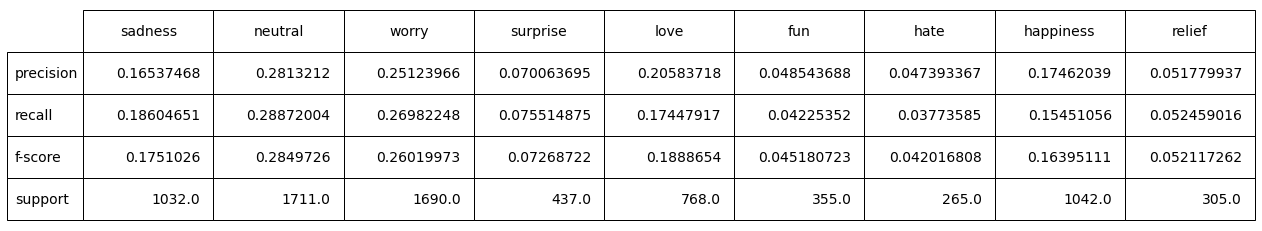

In [ ]:
#knn 1
neigh_1 = Classifier(KNeighborsClassifier(n_neighbors=1))
neigh_1.train(train_data[0], train_data[1])

neigh_1_pred = neigh_1.pred(test_data[0])
neigh_1.display_metrics(test_data[1], neigh_1_pred)

By observing the confusion matrix and the performance table we deduce that
 

1.   most examples - no matter their true class - are classified as either sadness, neutral, worry, happiness, and love. 
2.   The neutral class presents the best metrics, closely followed by worry. Love, happiness and sadness display similar performance and surprise, fun, hate, relief seem to perform poorly, as most of the examples are misclasiified. We also notice that in each class, the precision, recall and f-score, all take similar values.

This is expected, since,  as we mentioned earlier, there is a high class imbalance in the dataset. Most examples belong to neutral and worried, then happiness, sadness, love and very few examples in surprise, fun, relief, hate.

We also notice that the prediction execution time is much greater than the fitting one, which is compatible with the knn algorithm, since all the distance calculations (computations proportional to the dataset size) are executed in the prediction function. 



/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Function train took 0.0593 seconds
Function pred took 32.5047 seconds
set accuracy: 0.2235371466140697
confusion_matrix:


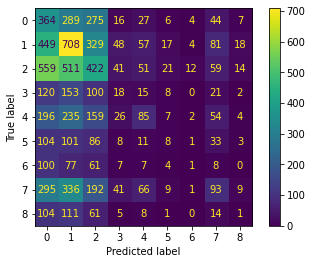

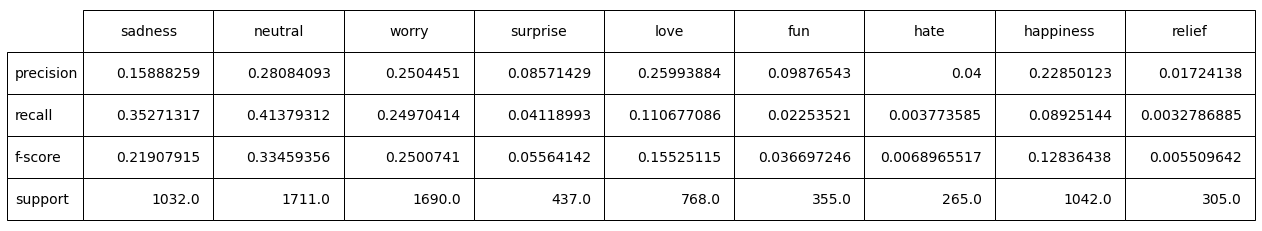

In [ ]:
#knn 3
neigh_3 = Classifier(KNeighborsClassifier(n_neighbors=3))
neigh_3.train(train_data[0], train_data[1])

neigh_3_pred = neigh_3.pred(test_data[0])
neigh_3.display_metrics(test_data[1], neigh_3_pred)

The 3 neighbors classifier seems to perform a little better than the 1 neighbor one although the bias towards the classes with more data examples applies here as well. Specifically, 


1.   we notice a slightly higher accuracy.
2.   Neutral is still the best performing class, with higher recall than precision. This means that the classifier tends to correctly classify the examples that belong to neutral, but also misclassifies as neutral, examples that belong to other classes. This is also backed by the confusion matrix.
3.   This problem is observed in the sadness class as well.
4.   The reverse applies to all the other classes, except from worry, where we observe higher precision than recall.
5.   Surprise, fun, hate, and relief continue to display poor performance compared to the other classes.

The better performance is compatible with the intuition that more neighbors lead to less biased, and therefore more accurate, results.

The prediction time is slightly bigger than the 1 neighbor case.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Function train took 0.1461 seconds
Function pred took 0.1000 seconds
set accuracy: 0.17435897435897435
confusion_matrix:


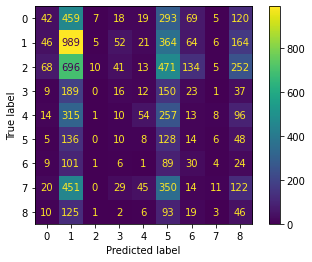

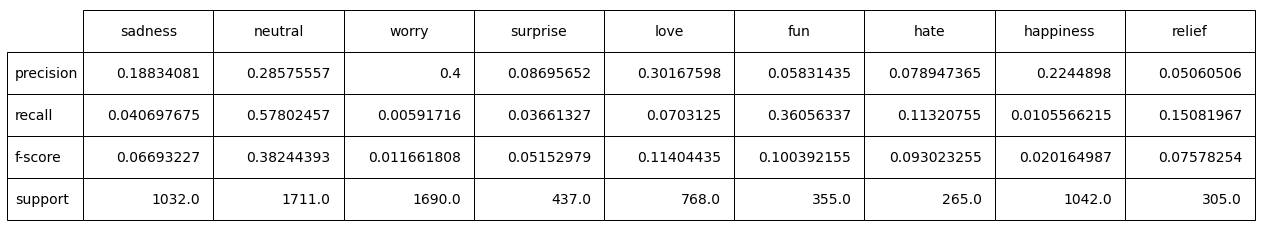

In [ ]:
#nearest centroid
nc = Classifier(NearestCentroid())
nc.train(train_data[0], train_data[1])

nc_pred = nc.pred(test_data[0])
nc.display_metrics(test_data[1], nc_pred)

This classifier has the lowest test set accuracy score.

The neutral class seems once again to perform better than the others since it has the highest f-score and recall. The confusion matrix indicates that most examples are classified as neutral even if they don't belong in the neutral class.

Neutral, fun, hate ,and relief have higher recall than precision. This is compatible with the visual representation of the confusion matrix, where the neutral (1), fun (5), and relief (8) columns are notably more blue-green than the others. 

The reverse is true for the other classes, where the precision is much higher than the recall.

In contrast with the knn classifiers, the nearest centroid classifier displays bigger fitting than prediction time. The fitting time is greater than in the knn algorithms, but the prediction time is significantly lower. This is due to the fact that the fit function computes the center of each class (computations proportional to the dataset size), whereas the predict function only needs to calculate the distance from each center (computations proportional to the number of classes).

All 3 classifiers display poor prformance, so the development of a more complex classifier appears necessary (coming soon).

#**Artificial Neural Network approach**

The architecture that was chosen is a 1d Convolutional Neural Network, which consists of 1 convolutional layer, followed by 2 linear layers. The reason is that we hope that the kernels will be able to capture correlation between words that are close to each other, and so the convolutional layer will work as a feature extractor for the immediately following classifier. The architecture is based on "*Convolutional Neural Networks for Sentence Classification, Yoon Kim"* [1].
 
For the CNN we will use one convolutional layer with multiple kernels of different sizes, and then a max-pooling layer, applied to each feature map produced by the convolution. After the max-pooling we have a value for each filter, and so we concatenate these values to end up with a 1d vector of length equal to the number of filters.
 
In [1] kernels of size 3, 4, and 5 are used and 100 filters are applied for each kernel size. The same parameters were used in our training, since it was proven computationally non-viable to tune for these parameters along with the other hyperparameters needed for training.

The pytorch framework is used.
 
*Illustration for (number_of_words = 7, embedding_dimensonality = 5) and kernel sizes 2, 3, and 4, with 2 filters each, source: Zhang, 2015.*


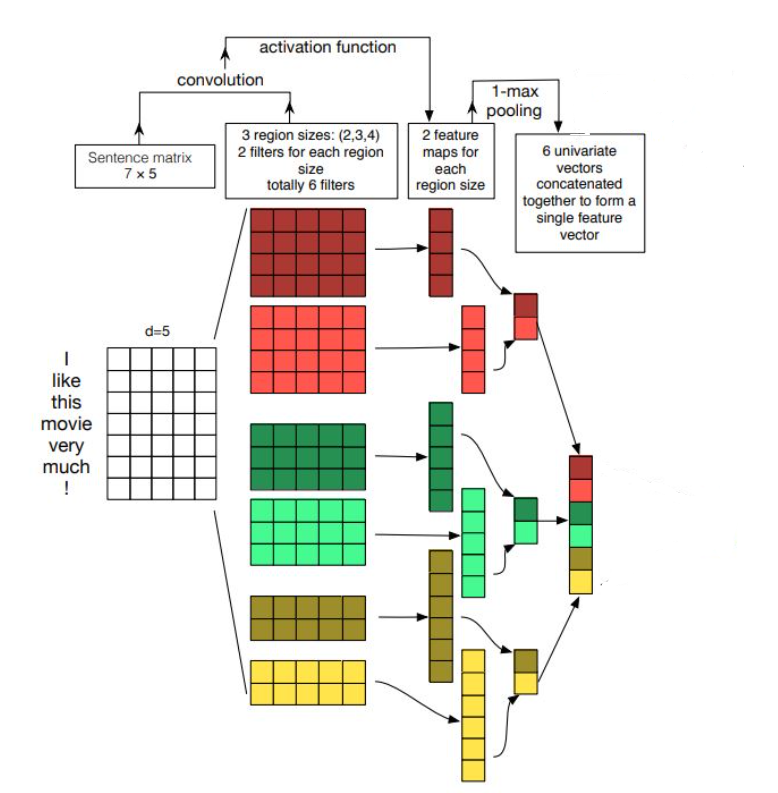

In [ ]:
######### colab really struggles in uploading photos in text cells :(, but modern problems require modern solutions :)
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread("cnn.png")
cv2_imshow(img)

The 1d vector is then considered the input to a one hidden layer classifier. Dropout is used in the input vector for regularization.

##**Split train test**

The CNN takes as input features the output of the Glove embedding.The embedding dimensionality is 25. The vectorized tweets are padded so every tweet has the same length (number of words). In the first part of the assignment the knn classifiers required the data to be one dimensional, so they were reshaped to (number_of_words * 25). For the CNN we prefer that each train input has a shape of (number_of_words, 25). To achieve this, a slightly modified 
get_train_test function (now named get_train_test_nn) was used.




In [ ]:
def get_train_test_nn(csv="tweet_emotions_processed.csv"):
    #clean text
    df = pd.read_csv(csv)
    df, text_labels = preprocess(df)
    df_text = df.copy()
    df.sentiment = df.sentiment.replace(dict(zip(df.sentiment.unique(), range(len(df.sentiment.unique())))))

    #vectorize text
    df = vectorize_data(df)

    x = df.content.values
    x = [x[i] for i in range(len(x))]
    x = [[x[i].astype(np.float32), i] for i in range(len(x))]
    #x = np.array(x)
    #x = torch.tensor(x)

    y = df.sentiment.values
    y = [y[i].astype(np.int_) for i in range(len(y))]
    y = np.squeeze(y)
    y = torch.tensor(y)

    x_train, x_test, y_train, y_test =  train_test_split(x, y, test_size=0.2, stratify=y)

    x_train = [x_train[i][0] for i in range(len(x_train))]
    x_test_data = [x_test[i][0] for i in range(len(x_test))]
    x_test_idx = [x_test[i][1] for i in range(len(x_test))]
    x_train = np.array(x_train)
    x_train = torch.tensor(x_train)
    x_test = x_test_data
    x_test = np.array(x_test)
    x_test = torch.tensor(x_test)
    


    return [[x_train, y_train], [x_test, y_test], x_test_idx, df_text]

##**Evaluation metrics**

In order to measure the accuracy of our model the multiclass_accuracy function was designed.

In [ ]:
import torch
import numpy as np

def binary_accuracy(y_hat: torch.Tensor, y: torch.Tensor, threshold=0.5) -> float:
    '''
    Parameters
    ----------
    y_hat : torch.Tensor
        1d predictions tensor
    y : torch.Tensor
        1d labels tensor
    threshold : float
        values larger or equal to threshold are consider 1., others 0.
        
    Returns
    -------
    float
        the number of correct predictions
    '''
    return (torch.where(y_hat >= threshold, 1., 0.) == y).sum().item()

def multiclass_accuracy(y_hat: torch.Tensor, y: torch.Tensor) -> float:
    '''
    Parameters
    ----------
    y_hat : torch.Tensor
        1d predictions tensor
    y : torch.Tensor
        1d labels tensor
    threshold : float
        values larger or equal to threshold are consider 1., others 0.
        
    Returns
    -------
    float
        the number of correct predictions
    '''
    return (torch.argmax(y_hat, dim=1) == y).sum().item()

##**Plots**

In [ ]:
from matplotlib import pyplot as plt

def plot_learning_curve(training_res: list, validation_res: list, metric: str, title: str, filename: str):
    '''
    plots the learning curve
    
    Parameters
    ----------
    training_res : array_like (1d)
        the training points to plot
    validation_res : array_like (1d)
        the validation points to plot
    metric : str
        the metric that is being plotted 
    title : str
        the title of the plot
    filename : str
        the file to save the plot
    '''
    fig, ax = plt.subplots()

    x = range(len(training_res))

    ax.plot(x, training_res, label="Training " + metric)
    ax.plot(x, validation_res, label="Validation " + metric)

    ax.legend()
    ax.set(xlabel="Epoch", ylabel=metric)
    ax.set_title(title)

    #fig.savefig(filename)
    plt.show()
    plt.close()

##**Dataloader**

In [ ]:
import sklearn.utils

class DataLoader():
    '''
    a DataLoader

    Parameters
    ----------
    dataset : list (iterbale)
        the dataset in the form [inputs, labels],
        inputs torch.Tensor(shape=(#training examples, #input features)),
        labels torch.Tensor(shape=(#training examples, #output features))
    batch_size : int
        batch size

    Attributes
    ----------
    dataset : list (iterbale)
        the dataset in the form [inputs, labels],
        inputs torch.Tensor(shape=(#training examples, #input features)),
        labels torch.Tensor(shape=(#training examples, #output features))
    batch_size : int
        batch size
    '''
    def __init__(self, dataset: list, batch_size: int):
        self.dataset, self.batch_size = dataset, batch_size
    def __iter__(self):
        '''

        Yields
        ----------
        list
            the next batch of the dataset in the form [inputs, labels]
        '''
        for i in range(0, len(self.dataset[0]), self.batch_size): yield (self.dataset[0][i:i+self.batch_size], self.dataset[1][i:i+self.batch_size])

    def shuffle(self):
      '''
      Shuffles the dataset
      '''
      self.dataset[0], self.dataset[1] = sklearn.utils.shuffle(self.dataset[0], self.dataset[1])

##**Neural network class for training**

In [ ]:
import torch

class NeuralNetwork():
    '''
    a neural network
    Parameters
    ----------
    model : torch.nn.Module
        the model to train,
    optimizer : torch.optim.Optimizer
        the optimizer used in training
    criterion : torch.nn.Module
        the loss function used in training
    metric_funcs : dict
        the metrics we want to compute, each key is a string with the metrics' name and value
        the function to compute it. 
        For every function it must be: function(predictions, labels) -> metric
    device : torch.device
        the device used for the training
    tag : str
        the nametag of the neural network
    Attributes
    ----------
    model : torch.nn.Module
        the model to train,
    optimizer : torch.optim.Optimizer
        the optimizer used in training
    criterion : torch.nn.Module
        the loss function used in training
    metric_funcs : dict
        the metrics we want to compute, each key is a string with the metrics' name and value
        the function to compute it. 
        For every function it must be: function(predictions, labels) -> metric
    device : torch.device
        the device used for the training
    tag : str
        the nametag of the neural network
    best_model_dict : dict
        dictionary containing information about the best model occurred during training
    '''
    def __init__(self, model, optimizer, criterion, metric_funcs: dict, device, tag: str):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.metric_funcs = metric_funcs
        self.device = device
        self.tag = tag
        self.best_model_dict = None

    def train_single_epoch(self, dataloader):
        '''
        implements the training of the model for a single epoch
        Parameters
        ----------
        dataloader : DataLoader
            a DataLoader for the training data
            
        Returns
        -------
        tuple (float, dict)
            the training loss and a dict of training metrics 
            where each key is a string of the metrics' name 
            with value the value for that metric computed over training
        '''
        train_metrics = dict(zip(self.metric_funcs.keys(), [0.0 for _ in range(len(self.metric_funcs.keys()))]))
        train_loss = 0.0
        samples = 0

        self.model.train()
        for xb, yb in dataloader:
            xb, yb = xb.to(self.device), yb.to(self.device)
            
            y_hat = self.model(xb)
            loss = self.criterion(y_hat, yb)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            train_loss += loss.item() * yb.size(0)
            for key in self.metric_funcs:
                train_metrics[key] += self.metric_funcs[key](y_hat, yb) 
            samples += yb.size(0)
        
        train_loss = train_loss / samples
        for key in self.metric_funcs:
            train_metrics[key] = train_metrics[key] / samples
        return train_loss, train_metrics

    def evaluate(self, dataloader):
        '''
        evaluates the model
        Parameters
        ----------
        dataloader : DataLoader
            a DataLoader for the evaluating data
            
        Returns
        -------
        tuple (float, dict)
            tha evaluating loss and a dict of training metrics 
            where each key is a string of the metrics' name 
            with value the value for that metric computed over evaluating
        '''
        eval_metrics = dict(zip(self.metric_funcs.keys(), [0.0 for _ in range(len(self.metric_funcs.keys()))]))
        eval_loss = 0.0
        samples = 0

        self.model.eval()
        with torch.no_grad():
            for xb, yb in dataloader:
                xb, yb = xb.to(self.device), yb.to(self.device)

                y_hat = self.model(xb)
                loss = self.criterion(y_hat, yb)
                
                eval_loss += loss.item() * yb.size(0)
                for key in self.metric_funcs:
                    eval_metrics[key] += self.metric_funcs[key](y_hat, yb)
                samples += yb.size(0)
        
        eval_loss = eval_loss / samples
        for key in self.metric_funcs:
            eval_metrics[key] = eval_metrics[key] / samples
        return eval_loss, eval_metrics

    @measure_time
    def fit(self, train_dataloader, val_dataloader, epochs):
        '''
        implements the training loop
        Parameters
        ----------
        train_dataloader : DataLoader
            a DataLoader for the training data
        val_dataloader : DataLoader
            a DataLoader for the validation data
        epochs: int
            the number of epochs to train the model
            
        Returns
        -------
        dict
            a dict with training and validation metrics for every epoch.
            dict['train'] and dict['validation] are dictionaries where each key is a string of the metrics' name 
            with value a tensor containing the calculated value of the metric at each epoch.
        '''
        train_loss = torch.empty(epochs)
        train_metrics = dict(zip(self.metric_funcs.keys(), [torch.empty(epochs) for _ in range(len(self.metric_funcs.keys()))]))
        val_loss = torch.empty(epochs)
        val_metrics = dict(zip(self.metric_funcs.keys(), [torch.empty(epochs) for _ in range(len(self.metric_funcs.keys()))]))

        min_val_loss = float('inf')

        for epoch in range(epochs):
            if epoch % 50 == 0:
              print(f"Model: {self.tag} Epoch: {epoch}")

            train = self.train_single_epoch(train_dataloader)
            val = self.evaluate(val_dataloader)

            train_dataloader.shuffle()
            #save metrics
            train_loss[epoch] = train[0]
            for key in self.metric_funcs.keys():
                train_metrics[key][epoch] = train[1][key]
            val_loss[epoch] = val[0]
            for key in self.metric_funcs.keys():
                val_metrics[key][epoch] = val[1][key]
            #save best model      
            if val_loss[epoch] < min_val_loss:
                min_val_loss = val_loss[epoch]
                self.best_model_dict = {
                        'epoch': epoch+1,
                        'model_state_dict': self.model.state_dict(),
                        'optimizer_state_dict': self.optimizer.state_dict(),
                        'training_metrics': {'loss': train[0], **train[1]},
                        'validation_metrics': {'loss': val[0], **val[1]}
                        }
        #plot learning curves                     
        plot_learning_curve(training_res=train_loss, validation_res=val_loss, metric='loss', title=self.tag, filename=f'{self.tag}_loss.png')
        for key in self.metric_funcs.keys():
            plot_learning_curve(training_res=train_metrics[key], validation_res=val_metrics[key], metric=key, title=self.tag, filename=f'{self.tag}_{key}.png')

        return {'train': {'loss': train_loss, **train_metrics}, 'validation': {'loss': val_loss, **val_metrics}}

##**Model**

This is the class that implements the architecture of our model. It consists of one 1d convolutional layer that applies in parallel multiple filters. The filters are specified in the *kernels* parameter. For each filter size we build a pytorch *Conv1d* layer with *in_channels* the dimensionality of the embedding, *out_channels* the number of filters of that size, and *kernel_size* the kernel size. All the filters are applied in the input of the neural network and then we apply max-pooling on each feature map produced by the convolution. Now that we have a feature representing each filter, we stack those features together and, after applying a dropout layer, we feed them to a linear classifier with one hidden layer. Between layers the ReLU activation function is applied. 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class CNN(nn.Module):
    def __init__(self, kernels, embedding_dim, h2, dropout, num_classes = 9):
        '''
        CNN model

        Parameters
        ----------
        kernels : dict
            a dictionary of kernel size: number of filters pairs
        embedding_dim: int
            the dimension our embedding projects each word
        h2: int
            number of neurons in the second linear layer
        dropout: float
            the dropout rate
        num_classes: int
            number of classes of the classification problem
        '''
        super().__init__()
        kernels_size = list(kernels.keys())
        num_kernels = list(kernels.values())
        self.conv_1_list = nn.ModuleList([
                nn.Conv1d(in_channels=embedding_dim, out_channels=num_kernels[i], kernel_size=kernels_size[i])
            for i in range(len(kernels_size))
            ])
        self.linear_1 = nn.Linear(np.sum(num_kernels), h2)
        self.relu = nn.ReLU()
        self.linear_2 = nn.Linear(h2, num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        x_conv_1_list = [F.relu(conv_1(x)) for conv_1 in self.conv_1_list]
        x_pool_1_list = [F.max_pool1d(x_conv_1, kernel_size=x_conv_1.shape[2]) for x_conv_1 in x_conv_1_list]
        x = torch.cat([x_pool_1.squeeze(dim=2) for x_pool_1 in x_pool_1_list], dim=1)
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear_2(x)
        return x

##**Hyper parameters tuning**

The *tune* function examines the performance of our architecture for different training and model parameters. The model hyperparameters we examine are neurons in the hidden linear layer, as well as the dropout rate. As mentioned before, we weren't able to examine different filter sizes and number of filters in the limited resources provided by collab. We also tune the learning rate. The batch size wasn't tuned, since we observed that a smaller batch size increases the training duration. In order to get more accurate validation metrics, k-cross validation is performed, with k=2, again due to limitation in the computational resources. During the tuning the model with the best validation performance is saved. Furthermore, in the end a dictionary containing the average validation performance of each model, for each epoch is returned.

For the training we use the Adam optimizer.

In [ ]:
import torch
from torch import nn
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 2048
EPOCHS = 100

def tune(hypers, train_data, criterion, metric_funcs):
    '''
    Tunes the model

    Parameters
    ----------
    hypers : list
        each element is a list hyper set containing a value for each hyperparameteer
    train_data: list
        the training data in the form [x_tranin: tensor, y_train: tensor]
    criterion: torch.nn.Module
        the loss function used in training
    metric_funcs: dict
        the metrics we want to compute, each key is a string with the metrics' name and value
        the function to compute it. 
        For every function it must be: function(predictions, labels) -> metric

    Returns
    -------
    val_performance: dict
        a dict with the average validation metrics among the k-folds for every model, for every epoch.
        val_performance[hyper_set] is a dictionary containing the metrics for the model with hyperparameters = hyper_set.
        val_performance[hyper_set][metric] is tensor with length = EPOCHS, containing the (average) metric for this model for every epoch.
    '''
    min_val_loss = float("inf")
    val_performance = {hyper_set: dict() for hyper_set in hypers}

    embedding_dim = train_data[0].shape[1]
    for hyper_set in hypers:
        lr = hyper_set[0]
        h2 = hyper_set[1]
        dropout = hyper_set[2]
        kernels = {3: hyper_set[3], 4: hyper_set[3], 5: hyper_set[3]}

        skf = StratifiedKFold(n_splits=2)
        for fold, (train_indices, val_indices) in enumerate(skf.split(train_data[0], train_data[1])):
            train = [train_data[0][[train_indices]], train_data[1][train_indices]]
            val = [train_data[0][val_indices], train_data[1][val_indices]]
            train_dataloader = DataLoader(train, batch_size)
            val_dataloader = DataLoader(val, batch_size)

            model = CNN(kernels, embedding_dim, h2, dropout)
            optimizer = optim.Adam(model.parameters(), lr=lr) 
            neural_net = NeuralNetwork(model, optimizer, criterion, metric_funcs, device, f"{lr}_{h2}_{dropout}_{kernels}")
            cur_performance = neural_net.fit(train_dataloader, val_dataloader, EPOCHS)

            for metric, metric_tensor in cur_performance['validation'].items():
                if metric not in val_performance[hyper_set]:
                    val_performance[hyper_set][metric] = metric_tensor
                else:
                    val_performance[hyper_set][metric] = val_performance[hyper_set][metric] + (1 / (fold+1)) * (metric_tensor - val_performance[hyper_set][metric])
            #save best model
            if neural_net.best_model_dict['validation_metrics']['loss'] < min_val_loss:
                min_val_loss = neural_net.best_model_dict['validation_metrics']['loss']
                best_model_dict = neural_net.best_model_dict.copy()
                best_model_dict['learning_rate'] = lr
                best_model_dict['neurons_hidden'] = h2
                best_model_dict['dropout'] = dropout
                best_model_dict['kernels'] = kernels
                torch.save(best_model_dict, 'best_model.pth')
    return val_performance

###Load data

In [ ]:
data = get_train_test_nn()
train_data = data[0]
test_data = data[1]
x_test_idx = data[2]
df_text = data[3]
train_data[0] = np.transpose(train_data[0], axes=[0, 2, 1]) #the convolution layer requires data in the form (batch_size, embedding_dim, sentence_length)
test_data[0] =  np.transpose(test_data[0], axes=[0, 2, 1])

[==================================================] 100.0% 104.8/104.8MB downloaded


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Model: 0.0001_64_0.2_{3: 100, 4: 100, 5: 100} Epoch: 0
Model: 0.0001_64_0.2_{3: 100, 4: 100, 5: 100} Epoch: 50


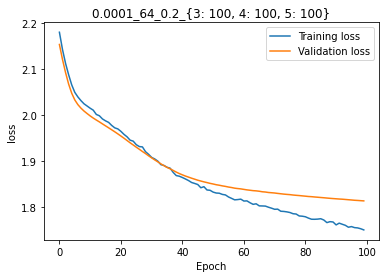

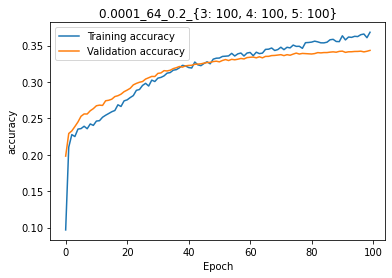

Function fit took 913.1636 seconds
Model: 0.0001_64_0.2_{3: 100, 4: 100, 5: 100} Epoch: 0
Model: 0.0001_64_0.2_{3: 100, 4: 100, 5: 100} Epoch: 50


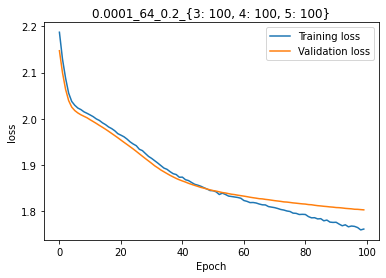

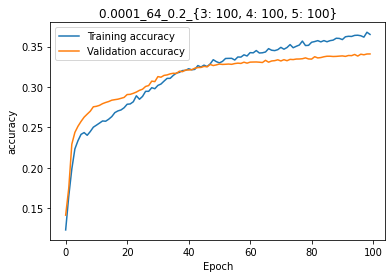

Function fit took 909.4069 seconds
Model: 0.0001_64_0.5_{3: 100, 4: 100, 5: 100} Epoch: 0
Model: 0.0001_64_0.5_{3: 100, 4: 100, 5: 100} Epoch: 50


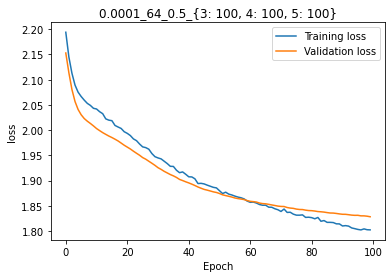

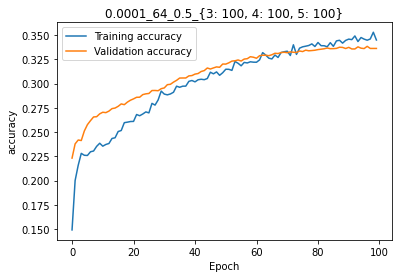

Function fit took 908.9471 seconds
Model: 0.0001_64_0.5_{3: 100, 4: 100, 5: 100} Epoch: 0
Model: 0.0001_64_0.5_{3: 100, 4: 100, 5: 100} Epoch: 50


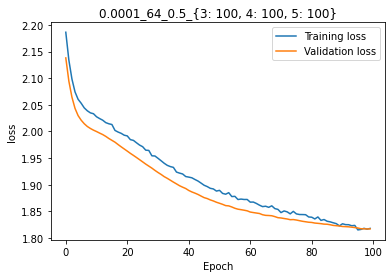

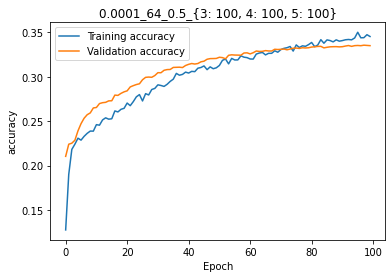

Function fit took 912.5951 seconds
Model: 0.0001_32_0.2_{3: 100, 4: 100, 5: 100} Epoch: 0
Model: 0.0001_32_0.2_{3: 100, 4: 100, 5: 100} Epoch: 50


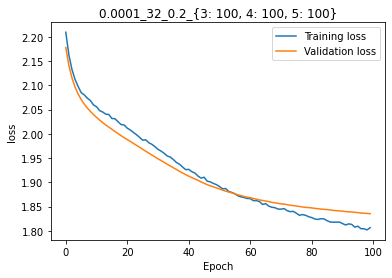

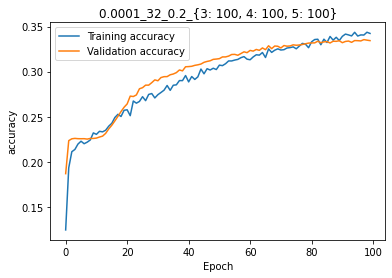

Function fit took 908.7658 seconds
Model: 0.0001_32_0.2_{3: 100, 4: 100, 5: 100} Epoch: 0
Model: 0.0001_32_0.2_{3: 100, 4: 100, 5: 100} Epoch: 50


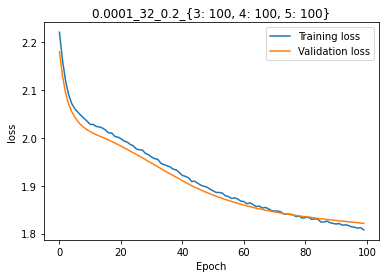

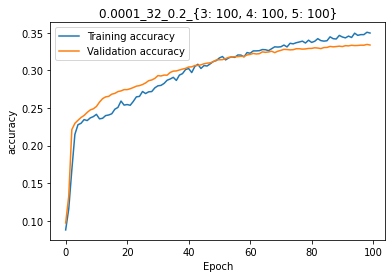

Function fit took 907.9552 seconds
Model: 0.0001_32_0.5_{3: 100, 4: 100, 5: 100} Epoch: 0
Model: 0.0001_32_0.5_{3: 100, 4: 100, 5: 100} Epoch: 50


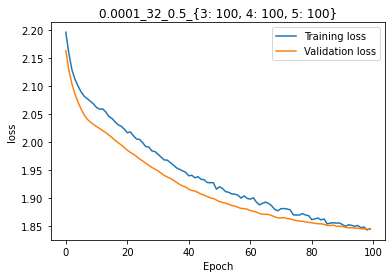

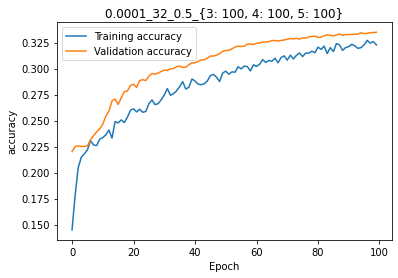

Function fit took 899.0365 seconds
Model: 0.0001_32_0.5_{3: 100, 4: 100, 5: 100} Epoch: 0
Model: 0.0001_32_0.5_{3: 100, 4: 100, 5: 100} Epoch: 50


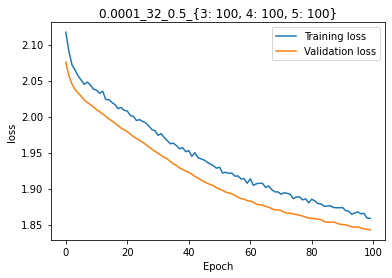

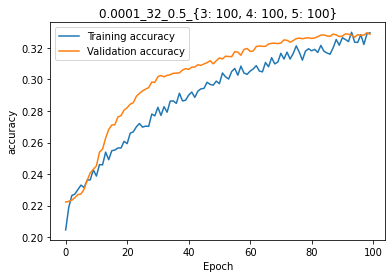

Function fit took 904.1126 seconds
Model: 0.001_64_0.2_{3: 100, 4: 100, 5: 100} Epoch: 0
Model: 0.001_64_0.2_{3: 100, 4: 100, 5: 100} Epoch: 50


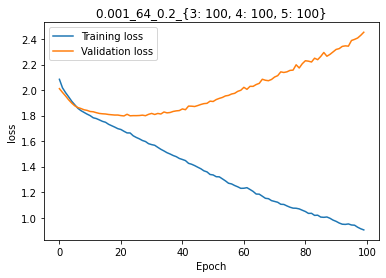

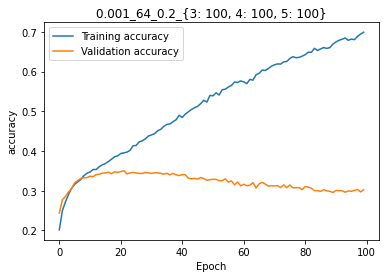

Function fit took 910.1230 seconds
Model: 0.001_64_0.2_{3: 100, 4: 100, 5: 100} Epoch: 0
Model: 0.001_64_0.2_{3: 100, 4: 100, 5: 100} Epoch: 50


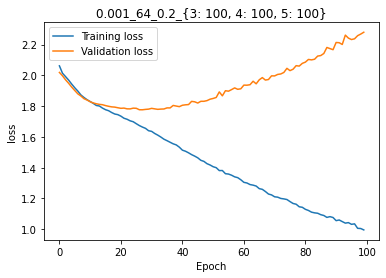

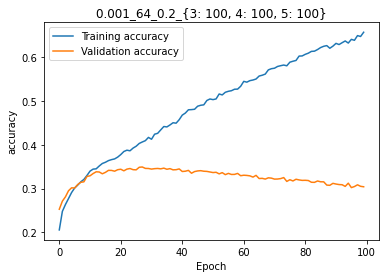

Function fit took 910.3525 seconds
Model: 0.001_64_0.5_{3: 100, 4: 100, 5: 100} Epoch: 0
Model: 0.001_64_0.5_{3: 100, 4: 100, 5: 100} Epoch: 50


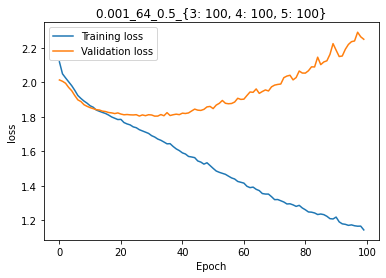

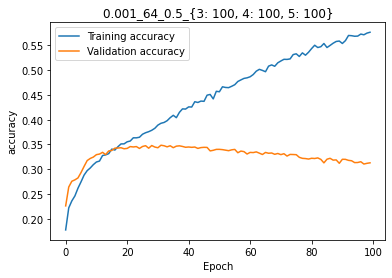

Function fit took 905.7840 seconds
Model: 0.001_64_0.5_{3: 100, 4: 100, 5: 100} Epoch: 0
Model: 0.001_64_0.5_{3: 100, 4: 100, 5: 100} Epoch: 50


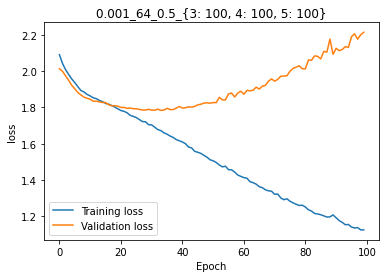

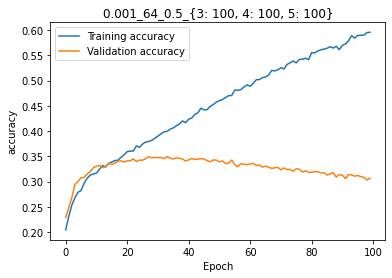

Function fit took 909.4857 seconds
Model: 0.001_32_0.2_{3: 100, 4: 100, 5: 100} Epoch: 0
Model: 0.001_32_0.2_{3: 100, 4: 100, 5: 100} Epoch: 50


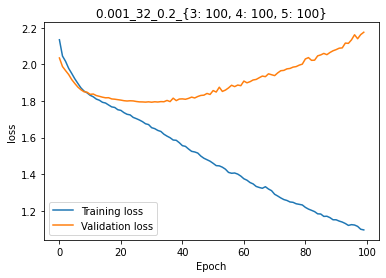

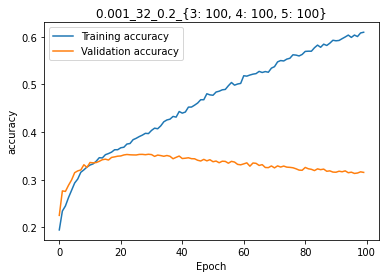

Function fit took 907.3574 seconds
Model: 0.001_32_0.2_{3: 100, 4: 100, 5: 100} Epoch: 0
Model: 0.001_32_0.2_{3: 100, 4: 100, 5: 100} Epoch: 50


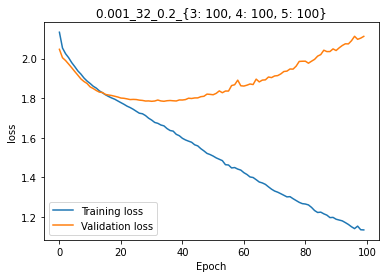

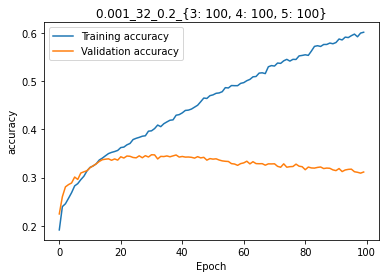

Function fit took 910.9769 seconds
Model: 0.001_32_0.5_{3: 100, 4: 100, 5: 100} Epoch: 0
Model: 0.001_32_0.5_{3: 100, 4: 100, 5: 100} Epoch: 50


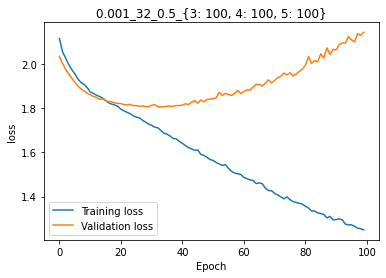

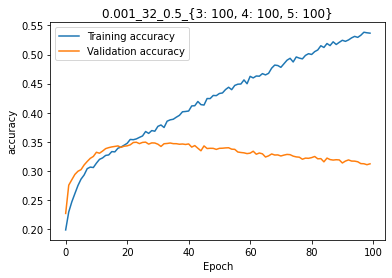

Function fit took 907.1944 seconds
Model: 0.001_32_0.5_{3: 100, 4: 100, 5: 100} Epoch: 0
Model: 0.001_32_0.5_{3: 100, 4: 100, 5: 100} Epoch: 50


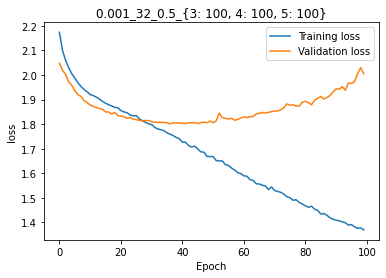

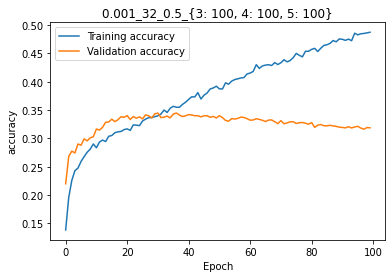

Function fit took 912.3648 seconds


In [ ]:
from itertools import product

test_dataloader = DataLoader(test_data, batch_size)

learning_rate = [0.0001, 0.001]
neurons_hidden = [64, 32]
dropout = [0.2, 0.5]
num_kernels = [100]
hypers = list(product(learning_rate, neurons_hidden, dropout, num_kernels))

criterion = nn.CrossEntropyLoss()
metric_funcs = {'accuracy': multiclass_accuracy}

val_performance = tune(hypers, train_data, criterion, metric_funcs)
torch.save(val_performance, 'val_performance.pth')

From the learning curves we deduce the following:

1. the models trained with learning rate 0.0001 take about 100 epochs to converge, whereas the models trained with learning rate 0.001 take about 10-40 epochs to converge and then they overfit.
2. Some of the models with learning rate 0.0001 look like they haven't exactly converge and could use some more epochs of training, but in multiple test runs we noticed that shortly after the 100 epochs they overfit, so we decided to do the tuning with 100 epochs to save some computational power without loosing crucial information.
3. All models achieve validation loss of about 1.8 and accuracy 0.3-0.35. This is certainly an improvement compare to the ~0.2 accuracy achieved by the knn classifiers. It still seems like a low accuracy score, but considering the number of classes (= 9), the highly imbalanced dataset, and the parameters that could be tuned, but didn't, due to computational limitations, it is a reasonable score.
4. The models with learning rate 0.0001 and 0.001 display similar metrics, but as mentioned, the models with learning rate 0.001 take less than half the epochs to train, so we will stick to one of the 0.001 models.
5. The models with 64 and 32 hidden neurons also display similar metrics so a model with 32 neurons is preferred, due to lower computational complexity.
6. By setting the learning rate to 0.001 and the hidden neurons to 32, we then compare the performance of the models with dropout 0.2 and 0.5. They also show similar performance, so the model with 0.5 dropout rate is chosen.

So the chosen model is the one with learning rate = 0.001, dropout rate = 0.5, hidden neurons = 32.


###Find best cross model

Aside from the learning curves, we can use the val_performance dictionary to compare the average performance of our models.

In [ ]:
def find_best_cross_model():
    val_performance = torch.load('val_performance.pth')

    min_loss = float('inf')
    for hyper_set in hypers:
        loss = list(val_performance[hyper_set]['loss'])
        min_cur_loss = min(loss)
        cur_epoch = loss.index(min_cur_loss)
        if min_cur_loss < min_loss:
            min_loss = min_cur_loss
            best_hyper_set = hyper_set
            epoch = cur_epoch + 1

    val_perf_model = dict()
    for metric, metric_tensor in val_performance[best_hyper_set].items():
        val_perf_model[metric] = metric_tensor.data[epoch - 1].item()

    print(
        f'\nBest average performance at:\n\
            learning rate: {best_hyper_set[0]}\n\
            #neurons: {best_hyper_set[1]}\n\
            epoch: {epoch}\n\n\
            ---Cross validation metrics---\n\
            {val_perf_model}'
        )

In [ ]:
find_best_cross_model()


Best average performance at:
            learning rate: 0.001
            #neurons: 64
            epoch: 27

            ---Cross validation metrics---
            {'loss': 1.788630485534668, 'accuracy': 0.3461982011795044}


The best average performance was achieved by a model with learning rate 0.001 and 64 hidden neurons, but the metrics are too similar to account for the increased computation needed in comparison with the 32 neurons. So we will stick to the model with 32 neurons.

##**Train and test the chosen model**

In [ ]:
from torch.nn.modules.normalization import LocalResponseNorm
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

EPOCHS = 25
batch_size = 2048
lr = 0.001
dropout = 0.5
h2 = 32

test_dataloader = DataLoader(test_data, test_data[0].shape[0]) #batch size equal to the number of test examples
train_dataloader = DataLoader(train_data, batch_size)

criterion = nn.CrossEntropyLoss()
metric_funcs = {'accuracy': multiclass_accuracy}

kernels = {3: 100, 4: 100, 5: 100}
embedding_dim = train_data[0].shape[1]

model = CNN(kernels, embedding_dim, h2, dropout)
optimizer = optim.Adam(model.parameters(), lr=lr) 
neural_net = NeuralNetwork(model, optimizer, criterion, metric_funcs, device, f"{lr}_{h2}_{dropout}_{kernels}")

#train
@measure_time
def train():
  for epoch in range(EPOCHS):
    train = neural_net.train_single_epoch(train_dataloader)
    train_dataloader.shuffle()

train()

Function train took 199.1704 seconds


Test set loss: 1.7877510786056519
Test set accuracay: 0.3523997370151216
confusion_matrix:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


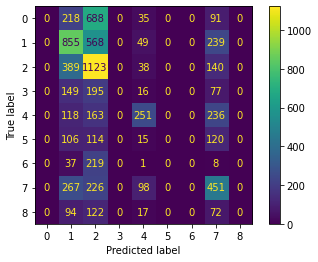

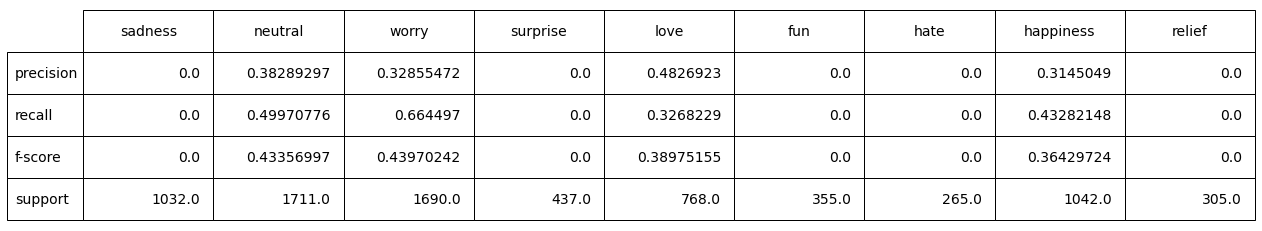

In [ ]:
import torch
from matplotlib import pyplot as plt
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             confusion_matrix, precision_recall_fscore_support)

def get_labels_text(csv="tweet_emotions_processed.csv"):
    df = pd.read_csv(csv)
    df, text_labels = preprocess(df)

    return text_labels

#test
test_loss = 0.0
test_accuracy = 0.0
samples = 0

neural_net.model.eval()
with torch.no_grad():
    for xb, yb in test_dataloader:
        xb, yb = xb.to(neural_net.device), yb.to(neural_net.device)

        y_hat = neural_net.model(xb)
        loss = neural_net.criterion(y_hat, yb)
        
        test_loss += loss.item() * yb.size(0)
        
        test_accuracy += multiclass_accuracy(y_hat, yb)
        samples += yb.size(0)

test_loss = test_loss / samples
test_accuracy = test_accuracy / samples

print(f"Test set loss: {test_loss}")
print(f"Test set accuracay: {test_accuracy}")

y_pred = y_hat.clone().detach()
y_pred = torch.argmax(y_pred, dim=1)
y_true = test_data[1]

#confusion matrix
print("confusion_matrix:")
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot()

#metrics table 
fig, ax  = plt.subplots() 
ax.axis('tight')
ax.axis('off')

prfs = precision_recall_fscore_support(y_true, y_pred)
prfs = np.array(prfs, dtype=np.float32)

columns = get_labels_text()
rows = ["precision", "recall", "f-score", "support"]

table = ax.table(cellText=prfs, rowLabels=rows, colLabels=columns, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(3.5, 3.5)

plt.show()
plt.close()

We see that we achieve better accuracy (\~0.35) than the knn classifiers (\~0.2)
 
The training also takes more time than that of the knn classifiers', but it is still considerably fast. The small number of epochs helps.
 
Despite the better accuracy the confusion matrix and the per class metrics table display a rather worse performance than that of the knn classifiers. Specifically:
 
1. All examples are classified as either neutral, worry, love, or happiness, despite their true label. Not one example is classified as sadness, surprise, fun, hate, or relief. So these classes score zero in every metric. This means that our classifier overfits the neutral, worry, love and happiness classes and completely neglects the other classes. For the classes Surprise, fun, hate, and relief we can justify our network's performance to the fact that these classes have very few training examples. The behavior in the sadness class is more unexpected, since sadness is one of the more dominant classes in the dataset, with more data points than love. 
2. The neutral and worry class score better recall than precision. This means that they classify correctly the examples that belong to the neutral and worry class, but they also misclassify,as neutral or worry, a lot of examples from other classes.
3. The love class displays the opposite behavior.
 
It is evident that the higher accuracy score is misleading and, overall, the behavior of the knn classifier is more desirable. Further tuning and selection criteria of the model (e.g. examine the confusion matrix along with the learning curves) could lead to better results. We should also try to fine tune the embedding to better suit the specific task. Furthermore, different architectures could be used, such as CNN with more layers, RNN, or a transformer.

##Some examples

In [ ]:
import pandas as pd 

labels = pd.DataFrame(list(zip(x_test_idx, np.array(y_true), np.array(y_pred))), columns=["index in df_text", "true", "predicted"])
labels.head()

,index in df_text,true,predicted
0,12860,1,2
1,11107,3,2
2,23078,2,2
3,1679,1,7
4,28726,4,7


In [ ]:
print(f"missclasified as worry, labeled as neutral: {df_text.content[12860]}\n")
print(f"missclasified as worry, labeled as surprise: {df_text.content[11107]}\n")
print(f"missclasified as happines, labeled as neutral: {df_text.content[1679]}\n")
print(f"clasified correctly as worry: {df_text.content[23078]}")

missclasified as worry, labeled as neutral:  made this huge revelation was doing the dishes( that everyone left for) and now totally forgot hate when that happens.

missclasified as worry, labeled as surprise: draven elbow met cement this afternoon looks nasty.

missclasified as happines, labeled as neutral:  month ahaha. and dunno can tomorrow lmao because went today freakin filipino parents aha

clasified correctly as worry:  not feel too bad, but not sure what should attribute that. could cold and flu meds; nap; alcohol getting better...


#**Training data selection with policy gradient**

An interesting idea I have wanted to try out for a while is to use reinforcement learning to select which data to feed to the neural network for training. There are some papers out there (not many) exploring the issue and displaying better results in comparison with the classic stochastic mini-batch data selection.

There are probably a lot of other things I could have tried to boost the performance of this specific neural network, but I just wanted to try it out :).

In "Learning What Data to Learn,
Yang Fan et al." [2] the authors train the policy on a subset of the dataset with policy gradient and then apply the policy on the whole dataset to train the network. I wanted to incorporate the training of the method with the training of the classifier, so I based my model on "Reinforced Training Data Selection for Domain Adaptation, Miaofeng Liu, et al." [3].

The architecture is the following:

We split our CNN in two, all the layers except the last are considered as a separate model ,the feature extractor, and the last layer is now the classifier. 

1. A training batch goes through the feature extractor. The output of the feature extractor follows then two paths:
2.1. goes straight into the classifier and the classifier computes the loss (*loss_original_batch*).
  2. is passed for every data point of the batch in parallel to our agent. 
  The agent is a linear neural network with one hidden layer. The input layer of the agent consists of *batch_size * output_features_of_feature_extractor* neurons and the output layer of *batch_size* neurons. So, the agent takes as input the 
  
    **state**, which is the feature representation for every data point in the batch, and **outputs** the probability of selecting each data point in the batch (**policy**). 

    Then, according to the policy, some data points from the batch are selected and are fed to the feature extractor and then the classifier. The classifier then computes the loss (*loss_selected*). 

    The **reward** of the agent is then computed as *(loss_original_batch - loss_selected) / loss_original_batc*. 

    The reason is that the more the loss is decreased due to the selection of the data points in comparison with the loss from the original batch the higher the *(loss_original_batch - loss_selected)*. The division with the original loss serves as a normalizer, since during training the losses will get smaller, despite the actions of the agent, and we don't want smaller rewards to be produced. 

    Finally, the agent network is updated through the policy gradient method. 

3. The classifier updates itself and the feature extractor from the *selected_loss*

*An illustration, modified image from [3]*


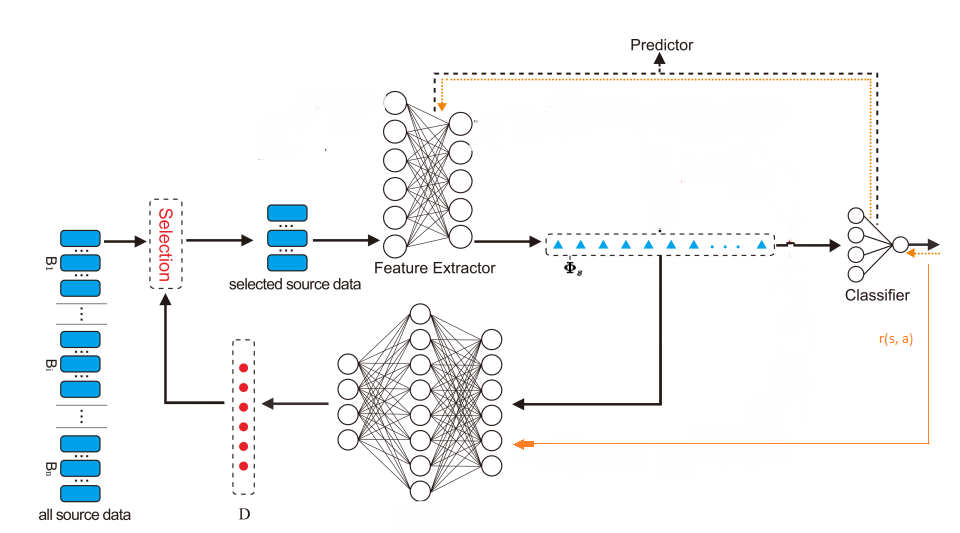

In [ ]:
######### colab really struggles in uploading photos in text cells :(, but modern problems require modern solutions :)
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread("rl.png")
cv2_imshow(img)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class FeatureExtractor(nn.Module):
    def __init__(self, kernels, embedding_dim, h2):
        super().__init__()
        kernels_size = list(kernels.keys())
        num_kernels = list(kernels.values())
        self.conv_1_list = nn.ModuleList([
                nn.Conv1d(in_channels=embedding_dim, out_channels=num_kernels[i], kernel_size=kernels_size[i])
            for i in range(len(kernels_size))
            ])
        self.linear_1 = nn.Linear(np.sum(num_kernels), h2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x_conv_1_list = [F.relu(conv_1(x)) for conv_1 in self.conv_1_list]
        x_pool_1_list = [F.max_pool1d(x_conv_1, kernel_size=x_conv_1.shape[2]) for x_conv_1 in x_conv_1_list]
        x = torch.cat([x_pool_1.squeeze(dim=2) for x_pool_1 in x_pool_1_list], dim=1)
        x = self.linear_1(x)
        x = self.relu(x)
        return x

class Classifier(nn.Module):
    def __init__(self, h2, dropout, num_classes = 9):
        super().__init__()
        self.linear_2 = nn.Linear(h2, num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        x = self.dropout(x)
        x = self.linear_2(x)

        return x

------EPOCH: 0-----


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train loss: 2.05946228689075
eval loss: 1.9594409465789795
------EPOCH: 1-----
train loss: 1.9659481677529673
eval loss: 1.8935613632202148
------EPOCH: 2-----
train loss: 1.91602284491166
eval loss: 1.8577735424041748
------EPOCH: 3-----
train loss: 1.8883975711916439
eval loss: 1.8425352573394775
------EPOCH: 4-----
train loss: 1.871697236413986
eval loss: 1.8307716846466064
------EPOCH: 5-----
train loss: 1.858561936408921
eval loss: 1.827378511428833
------EPOCH: 6-----
train loss: 1.846934310739933
eval loss: 1.8132942914962769
------EPOCH: 7-----
train loss: 1.833245201013494
eval loss: 1.8216054439544678
------EPOCH: 8-----
train loss: 1.8273211440852244
eval loss: 1.8131768703460693
------EPOCH: 9-----
train loss: 1.813677244851205
eval loss: 1.802503228187561
------EPOCH: 10-----
train loss: 1.804399323007279
eval loss: 1.7959790229797363
------EPOCH: 11-----
train loss: 1.7919294671463055
eval loss: 1.7971830368041992
------EPOCH: 12-----
train loss: 1.7865599810777322
eval l

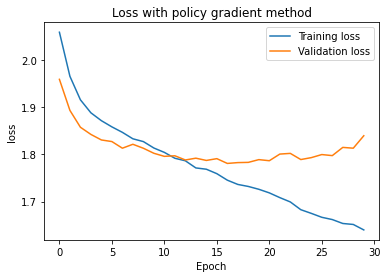

In [ ]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import itertools
from torch.distributions import Bernoulli
import numpy as np

def get_selected_train_batch(action, xb, yb):
    x_selected = xb[action == 1]
    y_selected = yb[action == 1]
    return x_selected, y_selected

#hyperparameters
batch_size = 512
learning_rate = 0.001
EPOCHS = 30

kernels = {3: 100, 4: 100, 5: 100}
embedding_dim = 25
h2 = 32
dropout = 0.5

policy_hn = 1500

#predictor network
feature_extractor = FeatureExtractor(kernels, embedding_dim, h2)
classifier = Classifier(h2, dropout)

predictor_params = [feature_extractor.parameters(), classifier.parameters()]
predictor_optimizer = torch.optim.Adam(itertools.chain(*predictor_params), learning_rate)

predictor_criterion = nn.CrossEntropyLoss()

#policy network
policy = nn.Sequential(nn.Linear(h2*batch_size, policy_hn), nn.ReLU(), nn.Linear(policy_hn, batch_size))
policy_optimizer = torch.optim.Adam(policy.parameters(), learning_rate)
 
#training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_dataloader = DataLoader(train_data, batch_size)

train_losses = list()
test_losses = list()

for epoch in range(EPOCHS):
    print(F"------EPOCH: {epoch}-----")
    train_loss = 0
    samples = 0
    train_dataloader.shuffle()
    for xb, yb in train_dataloader:

        #classification loss from train batch
        feature_extractor.train()
        classifier.train()
        xb, yb = xb.to(device), yb.to(device)

        features = feature_extractor(xb)
        y_hat = classifier(features)
        loss = predictor_criterion(y_hat, yb)

        if xb.shape[0] == batch_size:
            #select data from the data selector
            policy_state = np.reshape(features.clone().detach(), batch_size*h2)
            policy_state = policy_state.to(device)
            policy.train()

            policy_probs = policy(policy_state)
            policy_probs = F.normalize(policy_probs, dim=0)
            policy_probs = F.sigmoid(policy_probs)
            m = Bernoulli(policy_probs)
            action = m.sample()

            #classification loss from selected training data  
            x_next, y_next = get_selected_train_batch(action, xb.clone().detach(), yb.clone().detach())
            x_next, y_next = x_next.to(device), y_next.to(device)

            feat_next = feature_extractor(x_next)
            y_hat_next = classifier(feat_next)
            loss_next = predictor_criterion(y_hat_next, y_next)

            #compute reward, update policy parameters
            reward = (loss.clone().detach() - loss_next.clone().detach()) / loss.clone().detach()
            policy_loss = - m.log_prob(action) * reward
            policy_optimizer.zero_grad()
            policy_loss.backward(torch.ones_like(policy_loss))
            policy_optimizer.step()

            #update predictor parameters from next classification loss
            predictor_optimizer.zero_grad()
            loss_next.backward()
            predictor_optimizer.step()

        #update predictor parameters from first classification loss
        #predictor_optimizer.zero_grad()
        #loss.backward()
        #predictor_optimizer.step()  

        train_loss += loss.item() * yb.size(0)
        samples += yb.size(0)
    
    train_loss = train_loss / samples
    train_losses.append(train_loss)
    print(f"train loss: {train_loss}")

    #test
    eval_loss = 0.0

    feature_extractor.eval()
    classifier.eval()

    xb = test_data[0]
    yb = test_data[1]
    with torch.no_grad():
        xb, yb = xb.to(device), yb.to(device)

        features = feature_extractor(xb)
        y_hat = classifier(features)
        loss = predictor_criterion(y_hat, yb)
        
        eval_loss += loss.item() * yb.size(0)
    
    eval_loss = eval_loss / yb.size(0)
    test_losses.append(eval_loss)
    print(f"eval loss: {eval_loss}")

plot_learning_curve(train_losses, test_losses, "loss", "Loss with policy gradient method", "pol_grad_loss")
 

In [ ]:
y_pred = y_hat.clone().detach()
y_pred = torch.argmax(y_pred, dim=1)
y_true = test_data[1]

confusion_matrix:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


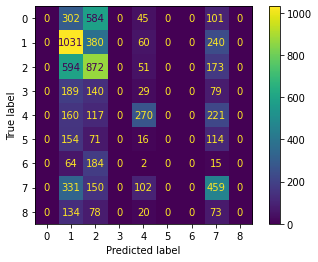

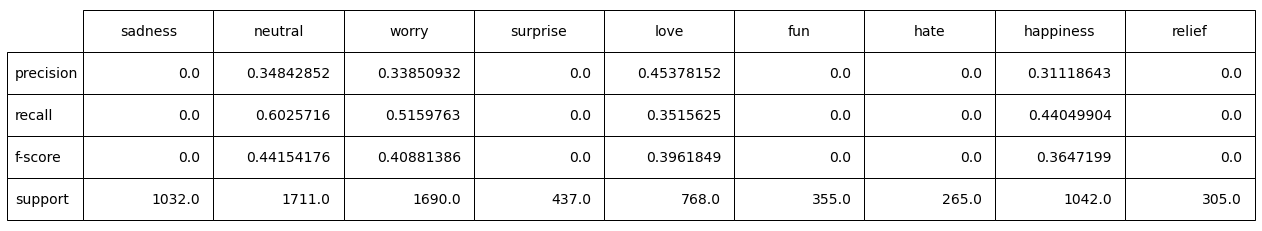

In [ ]:
import torch
from matplotlib import pyplot as plt
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             confusion_matrix, precision_recall_fscore_support)

def get_labels_text(csv="tweet_emotions_processed.csv"):
    df = pd.read_csv(csv)
    df, text_labels = preprocess(df)

    return text_labels

#confusion matrix
print("confusion_matrix:")
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot()

#metrics table 
fig, ax  = plt.subplots() 
ax.axis('tight')
ax.axis('off')

prfs = precision_recall_fscore_support(y_true, y_pred)
prfs = np.array(prfs, dtype=np.float32)

columns = get_labels_text()
rows = ["precision", "recall", "f-score", "support"]

table = ax.table(cellText=prfs, rowLabels=rows, colLabels=columns, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(3.5, 3.5)

plt.show()
plt.close()

The performance of the network is similar to the one with the stochastic mini batch data selection method. This is not a complete surprise, considering we haven't tuned the training hyper parameters, we used the first reward function that crossed our minds, and there are a lot of variations of the architecture that can be tried out, especially regarding when to update the target network and when the policy network. Also, we are working on an already problematic network that overfits to specific classes. Maybe we could come up with a reward that favors correct predictions on the classes with fewer examples, or replays those examples more times to overcome the overfitting problem.
